# Sprint 10: Integrated Project 2

**Project Description**

I will be working with data stored in three files from Zyfra, a gold mining company. Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar.

Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.

The source dataset contains the training and test sets with all the features.

I have the raw data that was only downloaded from the warehouse. Before building the model, check the correctness of the data. For that, I will be using the instructions given below:





1. Prepare the data

1.1. Open the files and look into the data.

Path to files:

- /datasets/gold_recovery_train.csv
- /datasets/gold_recovery_test.csv
- /datasets/gold_recovery_full.csv

1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

1.3. Analyze the features not available in the test set. What are these parameters? What is their type?

1.4. Perform data preprocessing.

2. Analyze the data

2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies. 

3. Build the model

3.1. Write a function to calculate the final sMAPE value.

3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.


# Prepare The Data


## 1.1 Open files and Look into Data


In [1]:
# Import Libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

In [2]:
# Read the Files
df_train = pd.read_csv('/datasets/gold_recovery_train.csv', index_col='date', parse_dates=True)
df_test = pd.read_csv('/datasets/gold_recovery_test.csv', index_col='date', parse_dates=True)
df_full = pd.read_csv('/datasets/gold_recovery_full.csv', index_col='date', parse_dates=True)

In [3]:
# Review Data for df_train
df_train.info()
display(df_train.shape)
display(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                     

(16860, 86)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


In [4]:
display(df_train.head(10))

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,115.581252,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,117.322323,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,124.592960,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,131.781026,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188


In [5]:
# Check for Missing Data
df_train.isnull().sum()

final.output.concentrate_ag                     72
final.output.concentrate_pb                     72
final.output.concentrate_sol                   370
final.output.concentrate_au                     71
final.output.recovery                         1521
                                              ... 
secondary_cleaner.state.floatbank5_a_level      85
secondary_cleaner.state.floatbank5_b_air        85
secondary_cleaner.state.floatbank5_b_level      84
secondary_cleaner.state.floatbank6_a_air       103
secondary_cleaner.state.floatbank6_a_level      85
Length: 86, dtype: int64

In [6]:
# Check for Duplicates
df_train.duplicated().sum()

16

In [7]:
# Review Data for df_test
df_test.info()
display(df_test.shape)
display(df_test.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5554 non-null   float64
 1   primary_cleaner.input.depressant            5572 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5690 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5840 

(5856, 52)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


In [8]:
display(df_test.head(10))

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,-497.903666,...,12.029797,-499.814895,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640
2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,-497.923683,...,12.026296,-499.473127,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984
2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,-503.451306,...,12.040911,-501.293852,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657
2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,-499.890350,...,11.998184,-499.481608,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716


In [9]:
# Check for Missing Data
df_test.isnull().sum()

primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257
rougher.input.floatbank10_xanthate            123


In [10]:
# Check for Duplicates
df_test.duplicated().sum()

6

In [11]:
# Review Data for df_full
df_full.info()
display(df_full.shape)
display(df_full.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                     

(22716, 86)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


In [12]:
display(df_full.head(10))

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,115.581252,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,117.322323,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,124.592960,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,131.781026,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188


In [13]:
# Check for Missing Data
df_full.isnull().sum()

final.output.concentrate_ag                     89
final.output.concentrate_pb                     87
final.output.concentrate_sol                   385
final.output.concentrate_au                     86
final.output.recovery                         1963
                                              ... 
secondary_cleaner.state.floatbank5_a_level     101
secondary_cleaner.state.floatbank5_b_air       101
secondary_cleaner.state.floatbank5_b_level     100
secondary_cleaner.state.floatbank6_a_air       119
secondary_cleaner.state.floatbank6_a_level     101
Length: 86, dtype: int64

In [14]:
# Check for Duplicates
df_full.duplicated().sum()

22

**DATA REVIEW**

- There is a 75/25 split among the training and testing data. In the training data, there are 87 columns and 16,860 rows. In the test data, there are 53 columns and 5,856 rows. And in the full data, there are 87 columns and 22,716 rows. I was able to find the ratio by the rows of data. 
- Each dataset has missing data that will need to be preprocessed and fixed before further analysis can be done. 
- I will also need to change the data type in the 'date' column for all three datasets. It is currently an object and I will be changing it to datetime. 
- Last but not least, the targets are 'rougher.output.recovery' and 'final.output.recovery'.

## 1.2  Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

In [15]:
# Function to Calculate Gold Recovery
def recovery(df, C, F, T):
    rec = 100 * ((df[C] * (df[F] - df[T])) / (df[F] * (df[C] - df[T])))
    return rec

# Applying functiom to Calculate Gold Recovery
vals_pred = recovery(df_train.dropna(subset=['rougher.output.recovery']), 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au')
vals_act = df_train['rougher.output.recovery'].dropna().to_list()

# Calculating the value
print(f'Mean Absolute Error: {mean_absolute_error(vals_act, vals_pred)}')

Mean Absolute Error: 9.303415616264301e-15


**Due to the near 0 MAE, we can conclude that there is little (or none) difference between the values of the original calculations and gold recovery calculations.**

## 1.3. Analyze the features not available in the test set. What are these parameters? What is their type?

In [16]:
# Finding features that are not present in the test set
df = pd.DataFrame()
list_columns = list(df_test.columns)
for col in list(df_train.columns):
    if col not in list_columns: 
        df[col] = df_train[col] 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                     

- Based on the analysis, the features that are not in the test set are data type 'float64' and they are all either an output or calculation. 
- There are a total of 34 missing parameters. 
    - 9 parameters are in the final stage.
    - 8 parameters are in the primary cleaner stage.
    - 13 parameters are in the rougher stage.
    - 4 parameters are in the secondary cleaner stage.
   

## 1.4. Perform data preprocessing

- There is missing data in each of the datasets. I will need to check to see if it's a significant amount that will need to filled in. Or if it's <5%, then I can simply drop them. To find the percentage, I will create a new dataset with the missing data dropped and calculate the percentage missing with the difference. 
- I will also need to change the data type in the 'date' column for all three datasets. It is currently an object and I will be changing it to datetime.

**Missing Data**

In [17]:
# Create new datasets without missing values
df_train_new = df_train.dropna() 
df_test_new = df_test.dropna()
df_full_new = df_full.dropna()

In [18]:
# Calculate the percentage of missing values in each dataset
print('Percentage of Missing Rows in Dataset Train Is', 100 - ((df_train_new.shape[0] / df_train.shape[0]) * 100), '%')
print('Percentage of Missing Rows in Dataset Test Is', 100 - ((df_test_new.shape[0] / df_test.shape[0]) * 100), '%')
print('Percentage of Missing Rows in Dataset Full Is', 100 - ((df_full_new.shape[0] / df_full.shape[0]) * 100), '%')

Percentage of Missing Rows in Dataset Train Is 34.65599051008303 %
Percentage of Missing Rows in Dataset Test Is 8.077185792349724 %
Percentage of Missing Rows in Dataset Full Is 29.151259024476133 %


**Since the percentage of missing data is above 5% for all data sets, I can not simply drop the rows with missing values. I will fill missing values with the column median. I will also now check for rows with missing targets, but those will be dropped as they would negatively effect my model.** 

In [19]:
# Checking for Rows with Missing Targets
df_train[['rougher.output.recovery', 'final.output.recovery']].isna().sum()

rougher.output.recovery    2573
final.output.recovery      1521
dtype: int64

In [20]:
# Checking for Rows with Missing Target
df_full[['rougher.output.recovery', 'final.output.recovery']].isna().sum()

rougher.output.recovery    3119
final.output.recovery      1963
dtype: int64

In [21]:
# Dropping Rows with Missing Targets
df_train = df_train.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])
df_full = df_full.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])

In [22]:
# Filling in missing values with the column median

df_train = df_train.fillna(df_train.median(numeric_only=True))
df_test = df_test.fillna(df_test.median(numeric_only=True))
df_full = df_full.fillna(df_full.median(numeric_only=True))

In [23]:
# Check for Missing Data
df_full.isnull().sum()

final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
final.output.recovery                         0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 86, dtype: int64

In [24]:
# Check for Missing Data
df_test.isnull().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

In [25]:
# Check for Missing Data
df_train.isnull().sum()

final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
final.output.recovery                         0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 86, dtype: int64

**Changing The Data Type**

In [26]:
#Checking Conversions
df_test.dtypes

primary_cleaner.input.sulfate                 float64
primary_cleaner.input.depressant              float64
primary_cleaner.input.feed_size               float64
primary_cleaner.input.xanthate                float64
primary_cleaner.state.floatbank8_a_air        float64
primary_cleaner.state.floatbank8_a_level      float64
primary_cleaner.state.floatbank8_b_air        float64
primary_cleaner.state.floatbank8_b_level      float64
primary_cleaner.state.floatbank8_c_air        float64
primary_cleaner.state.floatbank8_c_level      float64
primary_cleaner.state.floatbank8_d_air        float64
primary_cleaner.state.floatbank8_d_level      float64
rougher.input.feed_ag                         float64
rougher.input.feed_pb                         float64
rougher.input.feed_rate                       float64
rougher.input.feed_size                       float64
rougher.input.feed_sol                        float64
rougher.input.feed_au                         float64
rougher.input.floatbank10_su

In [27]:
##Checking Conversions
df_full.dtypes

final.output.concentrate_ag                   float64
final.output.concentrate_pb                   float64
final.output.concentrate_sol                  float64
final.output.concentrate_au                   float64
final.output.recovery                         float64
                                               ...   
secondary_cleaner.state.floatbank5_a_level    float64
secondary_cleaner.state.floatbank5_b_air      float64
secondary_cleaner.state.floatbank5_b_level    float64
secondary_cleaner.state.floatbank6_a_air      float64
secondary_cleaner.state.floatbank6_a_level    float64
Length: 86, dtype: object

# Analyze the Data

## 2.1 Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

In [28]:
#Plotting the Concentrations for Visual Comparisons

# List to create concentration plots
concentrate_au = ['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'secondary_cleaner.output.tail_au','final.output.concentrate_au']
concentrate_ag = ['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'secondary_cleaner.output.tail_ag','final.output.concentrate_ag']
concentrate_pb = ['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'secondary_cleaner.output.tail_pb','final.output.concentrate_pb']

# Creating a function to plot each concentration change that occurs
def plot_concentrate(data, list_stage):
    for stage in list_stage:
        data[stage].plot(kind='hist', legend=True, alpha=0.4)
        plt.xlabel('concentration')

**GOLD**

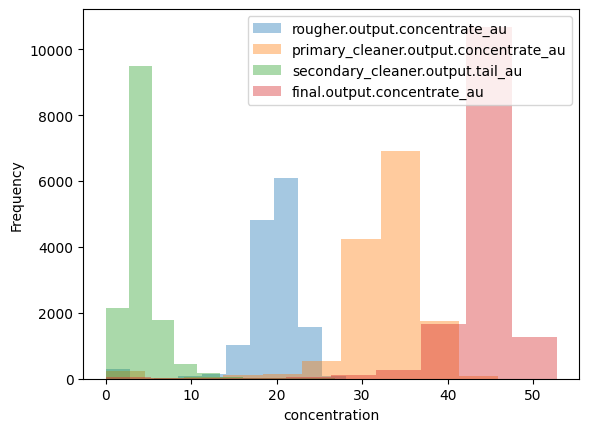

In [29]:
plot_concentrate(df_train, concentrate_au)

**SILVER**

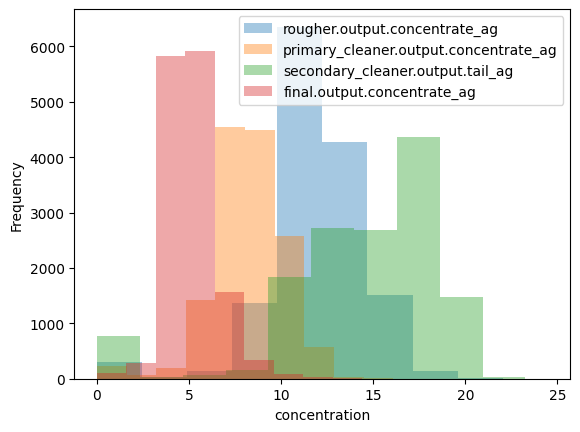

In [30]:
plot_concentrate(df_train, concentrate_ag)

**LEAD**

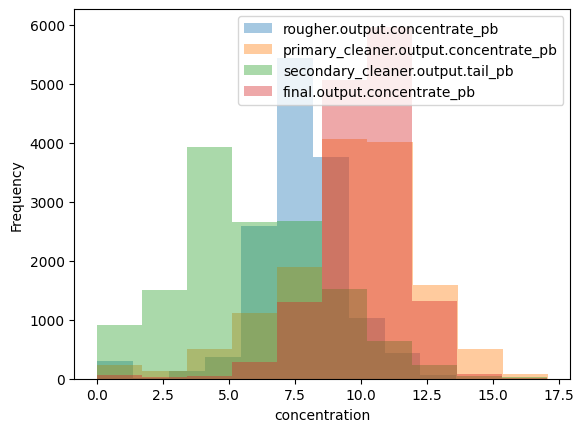

In [31]:
plot_concentrate(df_train, concentrate_pb)

From the graphs above, we can conclude the following:

GOLD
- There is an increase in concentration of gold from the initial purification stage to the final concentrate. It is the highest compared to Silver and Lead. 

SILVER
- There is no increase. It actually decreases throughout all the stages and the final concentrate contains a significantly low amount of concentrate.

LEAD
- There is a slight increase, but not a significant one compared to Gold. But it did perform better than Silver. 


## 2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

The two feed particle size features are rougher.input.feed_size and primary_cleaner.input.feed_size.

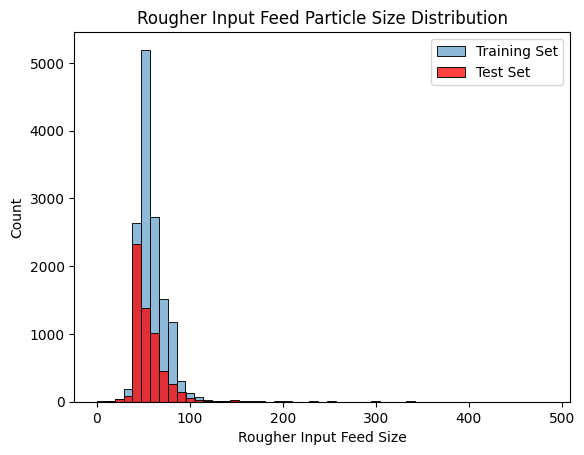

In [32]:
# Rougher Input Feed Size

sns.histplot(df_train['rougher.input.feed_size'], bins=50, label="Training Set", alpha=0.5) #Training Set
sns.histplot(df_test['rougher.input.feed_size'], bins=50, label="Test Set", color='red') #Test Set
plt.title("Rougher Input Feed Particle Size Distribution")
plt.legend()
plt.xlabel('Rougher Input Feed Size')
plt.show()

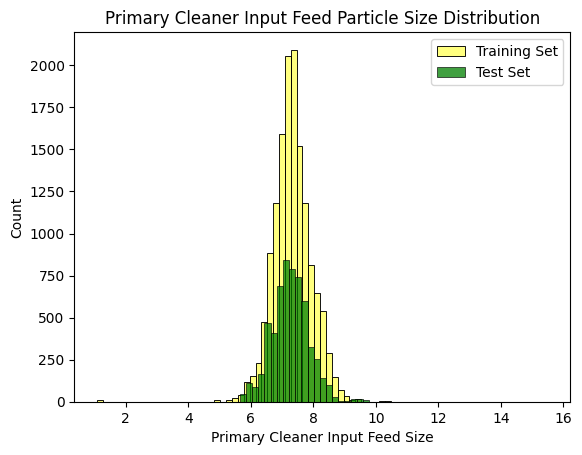

In [33]:
# Primary Cleaner Input Feed Size
sns.histplot(df_train['primary_cleaner.input.feed_size'], bins=50, label="Training Set", color='yellow', alpha=0.5) #Training Set
sns.histplot(df_test['primary_cleaner.input.feed_size'], bins=50, label="Test Set", color='green') #Test Set
plt.title("Primary Cleaner Input Feed Particle Size Distribution")
plt.legend()
plt.xlabel('Primary Cleaner Input Feed Size')
plt.show()

**Based on the graphs above, we can conclude that the distribution of feed particle sizes in the training set and test set do not have significant differences. However, I'd like to note that in ratio they do not differ, because the frequencies do differ substantially due to the differing data sizes between the two datasets.**

## 2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies. 

In [34]:
#Summing up concentrations of substances at each stage
raw_feed = df_full['rougher.input.feed_au'] + df_full['rougher.input.feed_ag'] + df_full['rougher.input.feed_pb']
rougher_concentrate = df_full['rougher.output.concentrate_au'] + df_full['rougher.output.concentrate_ag'] + df_full['rougher.output.concentrate_pb']
final_concentrate = df_full['final.output.concentrate_au'] + df_full['final.output.concentrate_ag'] + df_full['final.output.concentrate_pb']


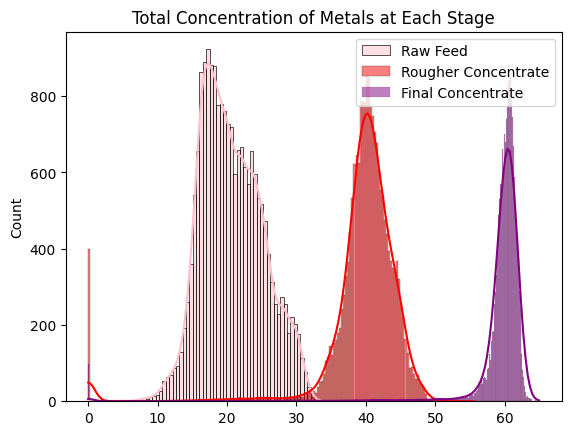

In [35]:
#Plot the total concentration of metals at certain stages
sns.histplot(data=raw_feed, color='pink', alpha=0.5, legend=True, kde=True, label='Raw Feed')
sns.histplot(data=rougher_concentrate, color='red', legend=True, kde=True, label='Rougher Concentrate')
sns.histplot(data=final_concentrate, color="purple", legend=True, kde=True, label='Final Concentrate')
plt.legend()
plt.title('Total Concentration of Metals at Each Stage')
plt.show()

**Based on the histogram above, the summed values have a considerable number of outliers as "0". The data in the histogram also shows a right-skewed distribution which can significantly impact the analysis and model-building process. Therefore, I will remove the outliers from the training data.**

**Removing Outliers - The '0' values**

In [36]:
#Concentrates
features_input_concentrate= ['rougher.input.feed_au','rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_sol',]
features_rough_concentrate = ['rougher.output.concentrate_au','rougher.output.concentrate_ag','rougher.output.concentrate_pb','rougher.output.concentrate_sol',]
features_final_concentrate = ['final.output.concentrate_au','final.output.concentrate_ag','final.output.concentrate_pb','final.output.concentrate_sol',]

threshold = 0.01

# Combine conditions for filtering
condition_input = (df_train[features_input_concentrate].sum(axis=1) > threshold)
condition_rough = (df_train[features_rough_concentrate].sum(axis=1) > threshold)
condition_final = (df_train[features_final_concentrate].sum(axis=1) > threshold)

# Only keep rows that satisfy all conditions
df_train_new = df_train[condition_input & condition_rough & condition_final]

print(df_train.shape)
print(df_train_new.shape)

(14149, 86)
(13795, 86)


# Build the Model

## 3.1. Write a function to calculate the final sMAPE value.

In [37]:
epsilon = 1e-10  # Small constant
def smape2(y_true, y_pred):
    with np.errstate(divide='ignore', invalid='ignore'):
        smape = np.nanmean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + epsilon))
    return smape
   


# Function to calculate final sMAPE
def fsmape(y_true, y_pred):
    # Assumes y_true and y_pred have two columns: [rougher, final]
    predicted_rough, predicted_final = y_pred[:, 0], y_pred[:, 1]
    true_rough, true_final = y_true[:, 0], y_true[:, 1]
    
    # Calculate sMAPEs and apply weights
    rougher_smape = smape2(true_rough, predicted_rough)
    final_smape = smape2(true_final, predicted_final)
    
    f_smape = (0.25 * rougher_smape) + (0.75 * final_smape)
    return f_smape


## 3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

**Data Prep**

In [38]:
#Training Features and Target
df_train_new = df_train_new.copy()

features_train = df_train_new
target_train = df_train_new[['rougher.output.recovery', 'final.output.recovery']]

In [39]:
#debugging
df_full = df_full.reindex(df_test.index)

In [40]:

#Testing Features and Target
df_test = df_test.copy()

features_test = df_test
target_test =  df_full[['rougher.output.recovery', 'final.output.recovery']].loc[df_test.index].reset_index(drop=True)

target_test.shape

(5856, 2)

In [41]:
# Transform dates into usable numerical features
if 'date' in features_train.columns:
    features_train['year'] = features_train['date'].dt.year
    features_train['month'] = features_train['date'].dt.month
    features_train = features_train.drop(columns=['date'])



In [42]:
print(features_train.head())

                     final.output.concentrate_ag  final.output.concentrate_pb  \
date                                                                            
2016-01-15 00:00:00                     6.055403                     9.889648   
2016-01-15 01:00:00                     6.029369                     9.968944   
2016-01-15 02:00:00                     6.055926                    10.213995   
2016-01-15 03:00:00                     6.047977                     9.977019   
2016-01-15 04:00:00                     6.148599                    10.142511   

                     final.output.concentrate_sol  \
date                                                
2016-01-15 00:00:00                      5.507324   
2016-01-15 01:00:00                      5.257781   
2016-01-15 02:00:00                      5.383759   
2016-01-15 03:00:00                      4.858634   
2016-01-15 04:00:00                      4.939416   

                     final.output.concentrate_au  final.outp

**Testing Models**

In [43]:

# Scoring function
cv_value = min(2, len(features_train))

def score_model(model, features, targets, cv=cv_value):
    scores = []
    kf = KFold(n_splits=cv, shuffle=True, random_state=54321)
    
    for subtrain_index, valid_index in kf.split(features):
        features_subtrain = features.iloc[subtrain_index].reset_index(drop=True)
        target_subtrain = targets.iloc[subtrain_index].reset_index(drop=True)
        features_valid = features.iloc[valid_index].reset_index(drop=True)
        target_valid = targets.iloc[valid_index].reset_index(drop=True)
        
        model.fit(features_subtrain, target_subtrain)
        pred_valid = pd.DataFrame(model.predict(features_valid))
        
        scores.append(fsmape(target_valid.values, pred_valid.values))
        
    return np.mean(scores)

# Initialize models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=54321)
rf = RandomForestRegressor(random_state=54321)

# Evaluate models
lr_score = score_model(lr, features_train, target_train)
dt_score = score_model(dt, features_train, target_train)
rf_score = score_model(rf, features_train, target_train)

print("Linear Regression sMAPE:", lr_score)
print("Decision Tree sMAPE:", dt_score)
print("Random Forest sMAPE:", rf_score)

Linear Regression sMAPE: 3.981920470289221e-14
Decision Tree sMAPE: 0.007249712434071611
Random Forest sMAPE: 0.0033230722998529357


In [44]:
# Reviewer's code 

df_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [45]:
# Reviewer's code 4.1

# Create dataframes

l = {'A':[1,2,4], 'B':[3,3,5]}

df1 = pd.DataFrame(l)

df2 = df1

df3 = df1.copy() 

display(df1, df2, df3)

,A,B
0,1,3
1,2,3
2,4,5


,A,B
0,1,3
1,2,3
2,4,5


,A,B
0,1,3
1,2,3
2,4,5


In [46]:
# Reviewer's code 4.2

df2.loc[0, 'A'] = 'change2'

df3.loc[1, 'A'] = 'change3'

display(df1, df2, df3)

,A,B
0,change2,3
1,2,3
2,4,5


,A,B
0,change2,3
1,2,3
2,4,5


,A,B
0,1,3
1,change3,3
2,4,5


In [47]:
#debugging
common_columns = features_train.columns.intersection(features_test.columns)
features_train = features_train[common_columns]
features_test = features_test[common_columns]


In [48]:
#Resetting the index
features_train = features_train.reset_index(drop=True)
features_test = features_test.reset_index(drop=True)

In [49]:
print(features_test.index)

RangeIndex(start=0, stop=5856, step=1)


In [50]:
print(features_train.index)

RangeIndex(start=0, stop=13795, step=1)


In [51]:
print("Training features count:", features_train.shape[1])

Training features count: 52


In [52]:
print("Testing features count:", features_test.shape[1])

Testing features count: 52


In [53]:
# Train the best model on the entire training set
best_model = RandomForestRegressor(random_state=54321)
best_model.fit(features_train, target_train)

# Make predictions on the test set
predictions = best_model.predict(features_test)

In [54]:
y_true = target_test   
y_pred = predictions

# Reshaping
y_true = target_test.values.reshape(-1, 1)
y_pred = predictions.reshape(-1, 1)

In [55]:
print(target_test.shape)

(5856, 2)


In [56]:
print(predictions.shape)

(5856, 2)


In [57]:
   def fsmape(y_true, y_pred):
       # Extract the columns
       true_rough, true_final = y_true[:, 0], y_true[:, 1]
       pred_rough, pred_final = y_pred[:, 0], y_pred[:, 1]

       # Calculate sMAPEs
       rougher_smape = smape2(true_rough, pred_rough)
       final_smape = smape2(true_final, pred_final)
       
       # Calculate the weighted f_smape
       f_smape = 0.25 * rougher_smape + 0.75 * final_smape
       return f_smape
   

In [58]:
# For DataFrame
true_rough = target_test.iloc[:, 0]
true_final = target_test.iloc[:, 1]

# For NumPy array
pred_rough = predictions[:, 0]
pred_final = predictions[:, 1]

y_true = np.column_stack((true_rough, true_final))
y_pred = np.column_stack((pred_rough, pred_final))

# Now call the scoring function
test_score = fsmape(y_true, y_pred)

In [59]:
print("Zeros in y_true:", np.sum(y_true == 0))
print("Zeros in y_pred:", np.sum(y_pred == 0))

Zeros in y_true: 137
Zeros in y_pred: 0


In [60]:
print(f"sMAPE score for best model on test dataset: {test_score}")

sMAPE score for best model on test dataset: 0.10477733727394942


## CONCLUSION

##### 
**DATA REVIEW**

- I was originally provided three datasets, full data, train data and test data. The train data and test data are from the full data. There is a 75/25 split among the training and testing data. In the training data, there are 87 columns and 16,860 rows. In the test data, there are 53 columns and 5,856 rows. And in the full data, there are 87 columns and 22,716 rows. I was able to find the ratio by the rows of data.
- After further review, I found that there were missing data that I needed to check to see if I could simply drop it or if the values needed to be filled in. 
- There was also incorrect data type for the purpose of this project that needed a conversion.
- Last but not least, I identified the targets as 'rougher.output.recovery' and 'final.output.recovery'

**DATA PREPROCESSING**

- The data type of date has been converted to datetime, and then converted to integers when it came time to test models.
- The missing columns were over 5%, so I filled it in with the column median. 

**EDA**

- CONCENTRATIONS: There is an increase in concentration of gold from the initial purification stage to the final concentrate. It is the highest compared to Silver and Lead. For Silver, there is no increase. It actually decreases throughout all the stages and the final concentrate contains a significantly low amount of concentrate. And for Lead, there is a slight increase, but not a significant one compared to Gold. But it did perform better than Silver.
- OUTLIERS: Based on the histogram for the concentrations, the summed values had a considerable number of outliers as "0". The data in the histogram also showed a right-skewed distribution which can significantly impact the analysis and model-building process. Therefore, I removed the zeros. 
- TRAINING AND TESTING MODELS: Based on the sMAPE values, the lowest value is shown in the Random Forest model. When tested on the test set, the Random Forest model obtained an sMAPE of 11.15.